# Example of a two-dimensional constrained Gaussian Process

In [72]:
import torch
import gpytorch
from src.models.constrained_gp_model import ConstrainedGPAgrell
import matplotlib.pyplot as plt

In [73]:
# Objective function
def objective_func(x1, x2):
    return 0.4 * torch.square(x1) +0.4 * torch.square(x2) - 6

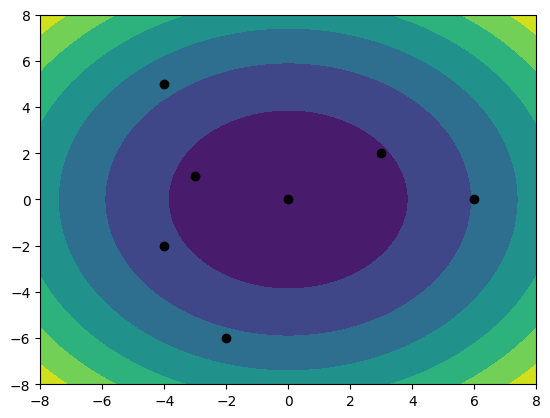

In [74]:
noise = 0.1

# define train points
x_train = torch.Tensor([[-2, -6], [3, 2], [-4, -2], [-3, 1], [6, 0], [-4, 5], [0, 0]])
y_train = objective_func(x_train[:, 0], x_train[:, 1]) + torch.normal(mean=0, std=torch.ones_like(x_train[:, 0])*noise,)


X = torch.linspace(-8, 8, 50)
Y = torch.linspace(-8, 8, 50)

X, Y = torch.meshgrid(X, Y)
Z = objective_func(X, Y)

fig = plt.figure()
plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.show()
plt.close()

In [75]:
X1_test, X2_test = X.reshape(-1, 1), Y.reshape(-1, 1)
X_test = torch.cat((X1_test, X2_test), dim=1)
print(X_test.shape)

torch.Size([2500, 2])


In [76]:
constrained_dims = [] # list of constrained dimensions
unconstrained_dims = [0, 1] # list of unconstrained dimensions

model_unconstrained = ConstrainedGPAgrell(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    unconstrained_dims=unconstrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(2, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),
    prior_mean=-2.)
model_unconstrained.likelihood.noise_covar.noise = noise ** 2

In [77]:
# unconstrained GP
prediction_unconstrained = model_unconstrained.posterior(X=X_test)
unconstrained_mean = prediction_unconstrained.mean.detach().numpy().reshape(-1)
unconstrained_std = torch.sqrt(prediction_unconstrained.variance.detach()).numpy().reshape(-1)


In [78]:
from src.models.gradient_predict_gp_model import DerivativeExactGPSEModel
model_grad = DerivativeExactGPSEModel(
    x_train, y_train,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(4, 2),
    prior_mean=-2.)
model_grad.likelihood.noise_covar.noise = noise ** 2


prediction_mean, prediction_var = model_grad.posterior_derivative(X_test)
grad_mean = prediction_mean.detach().numpy()
grad_std = torch.sqrt(prediction_var.detach()).numpy()

In [79]:
opt_model_grad = DerivativeExactGPSEModel(
    x_train, y_train,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 10),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(4, 10),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 2),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),
    prior_mean=-2.)
opt_model_grad.likelihood.noise_covar.noise = noise ** 2
opt_model_grad.likelihood.noise_covar.raw_noise.requires_grad = False

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

mll = ExactMarginalLogLikelihood(opt_model_grad.likelihood, opt_model_grad)
fit_gpytorch_model(mll)

prediction = opt_model_grad(X_test)
opt_mean = prediction.mean.detach().numpy()
opt_std = torch.sqrt(prediction.variance.detach()).numpy()

prediction_mean, prediction_var = opt_model_grad.posterior_derivative(X_test)
opt_grad_mean = prediction_mean.detach().numpy()
opt_grad_std = torch.sqrt(prediction_var.detach()).numpy()

In [80]:
constrained_dims = [0] # list of constrained dimensions
unconstrained_dims = [1] # list of unconstrained dimensions

model_constrained = ConstrainedGPAgrell(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    unconstrained_dims=unconstrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(2, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),
    prior_mean=-2.)
model_constrained.likelihood.noise_covar.noise = noise ** 2


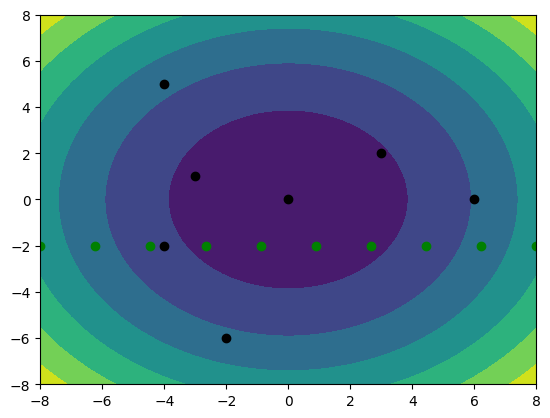

In [81]:
# define virtual observation locations
xv_points = torch.linspace(-8, 8, 10).reshape(-1, 1)
dummy_dim = torch.zeros(xv_points.shape[0]).reshape(-1, 1)

if constrained_dims[0]==1:
    xv_points = torch.cat((dummy_dim-2, xv_points), dim=1)
else:
    xv_points = torch.cat((xv_points, dummy_dim-2), dim=1)

fig = plt.figure()
plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.show()
plt.close()

In [82]:
posterior_options = {'evaluate_constrained': True,
                     'virtual_oberservation_points': xv_points,
                     'nr_samples': 1000}

# constrained GP
prediction_constrained = model_constrained.posterior(X=X_test, observation_noise=False, **posterior_options)
constrained_mean = prediction_constrained.mean.detach().numpy().reshape(-1)
constrained_std = torch.sqrt(prediction_constrained.variance.detach()).numpy().reshape(-1)

Start minimax algorithm (Python implementation) for 1000 samples (D=10)...
Time taken for 1000 samples: 0.01s.


/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


In [83]:
 # get samples from unconstrained model
samples_unconstrained = model_unconstrained.get_samples_from_last_posterior(3)

# get samples from constrained model
samples_constrained = model_constrained.get_samples_from_last_posterior(3)

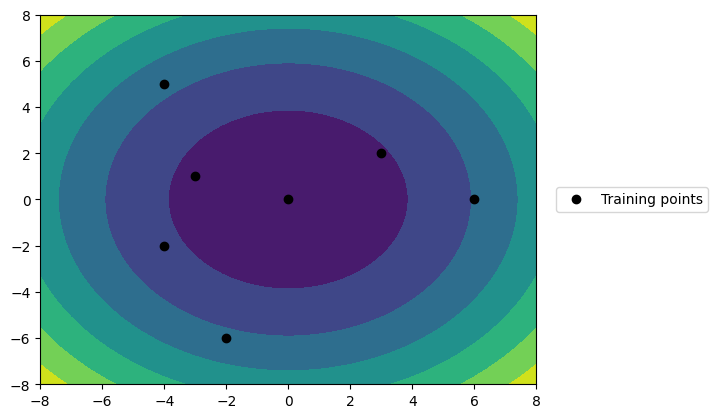

In [84]:
plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

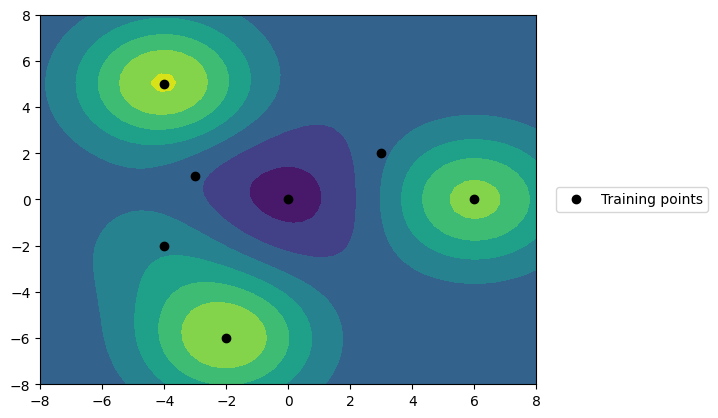

In [85]:
# unconstrained posterior
plt.contourf(X.numpy(), Y.numpy(), unconstrained_mean.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

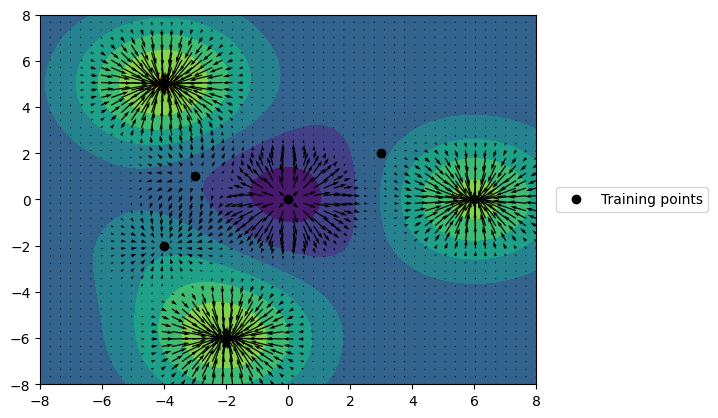

In [86]:
# unconstrained posterior grad
plt.contourf(X.numpy(), Y.numpy(), unconstrained_mean.reshape(50, 50), cmap='viridis')
plt.quiver(X.numpy(), Y.numpy(), grad_mean[:,0], grad_mean[:,1])
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

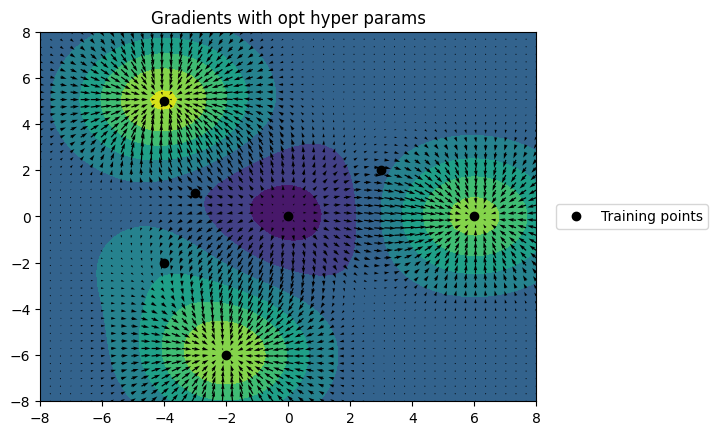

Gradients at the training points
(tensor([[-0.0881,  0.1099],
        [ 1.9751, -0.2883],
        [-0.1855, -1.3085],
        [-1.5853,  1.0412],
        [ 0.2303, -0.1098],
        [-0.0791,  0.2475],
        [ 0.1600, -0.3472]], grad_fn=<UnsafeViewBackward0>), tensor([[[5.4388e-01, 5.3179e-03],
         [5.3179e-03, 5.3584e-01]],

        [[4.6802e-01, 1.0000e-09],
         [1.0000e-09, 5.0964e-01]],

        [[5.2725e-01, 1.0000e-09],
         [1.0000e-09, 4.4304e-01]],

        [[4.4058e-01, 5.4245e-03],
         [5.4245e-03, 4.2237e-01]],

        [[5.0684e-01, 2.6696e-02],
         [2.6696e-02, 5.2851e-01]],

        [[5.4502e-01, 6.2716e-03],
         [6.2716e-03, 5.2110e-01]],

        [[4.1712e-01, 3.2224e-03],
         [3.2224e-03, 5.1107e-01]]], grad_fn=<ClampMinBackward0>))


In [87]:
plt.contourf(X.numpy(), Y.numpy(), opt_mean.reshape(50, 50), cmap='viridis')
plt.quiver(X.numpy(), Y.numpy(), opt_grad_mean[:,0], opt_grad_mean[:,1])
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title("Gradients with opt hyper params")
plt.show()

print("Gradients at the training points")
print(opt_model_grad.posterior_derivative(x_train))

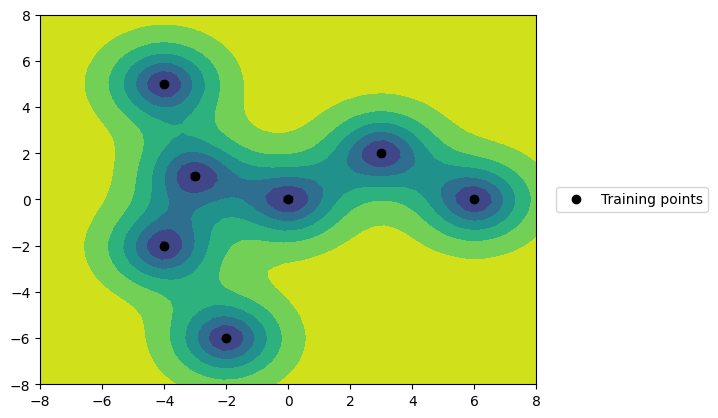

In [88]:
# unconstrained posterior stdv
plt.contourf(X.numpy(), Y.numpy(), unconstrained_std.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

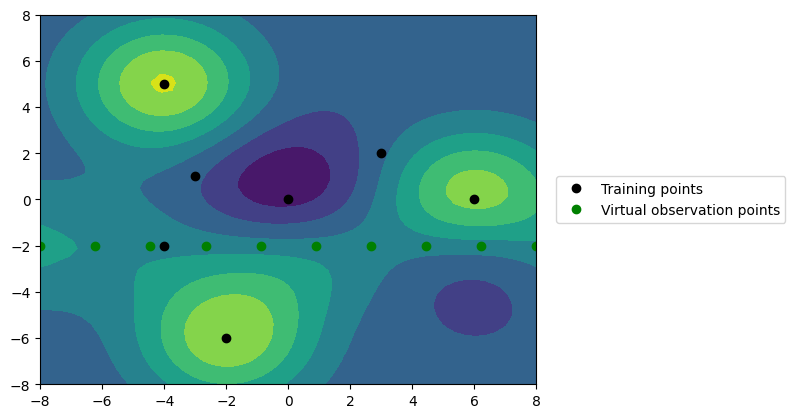

In [89]:
# constrained posterior
plt.contourf(X.numpy(), Y.numpy(), constrained_mean.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

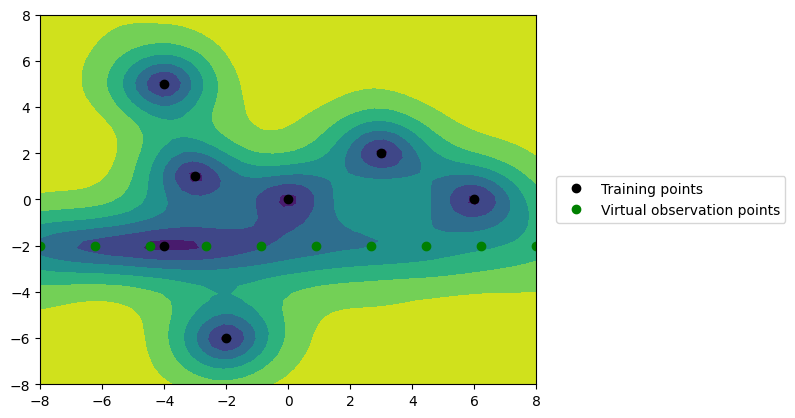

In [90]:
# constrained posterior stdv
plt.contourf(X.numpy(), Y.numpy(), constrained_std.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

In [91]:
samples_constrained.shape

torch.Size([2500, 3])

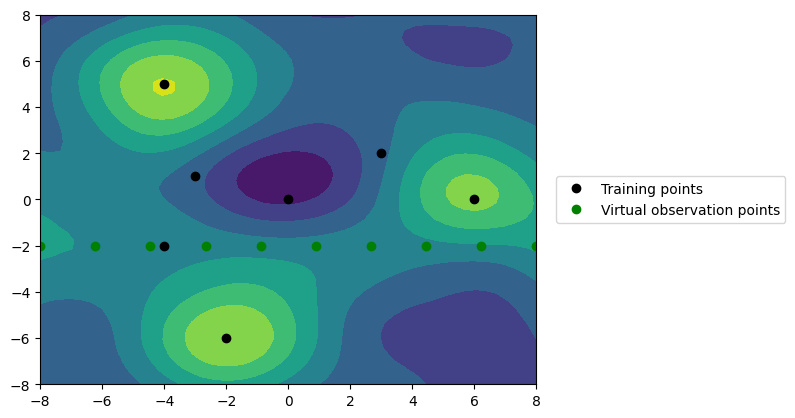

In [92]:
# sample constrained posterior
plt.contourf(X.numpy(), Y.numpy(), samples_constrained[:, 0].reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()